## Transparency: Explaining Classifiers, with LIME
#### Goals: Explaining classifiers and doing feature selection based on a set of explanations. Using the open-source [LIME library](https://github.com/marcotcr/lime) proposed in [Ribeiro et al., 2016](https://dl.acm.org/citation.cfm?doid=2939672.2939778) to generate locally interpretable explanations of classification decisions and using these for feature selection to improve accuracy.

Assignment created by Julia Stoyanovich: https://dataresponsibly.github.io/courses/spring20/

In [1]:
import lime
import lime.lime_tabular
import lime.lime_text
import sklearn
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import sparse
import random

random.seed(19)
np.random.seed(1)

#### Importing the [20 newsgroups dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) from sklearn.datasets which  comprises around 18000 newsgroups posts on 20 topics. Importing the two-class subset Atheism and Christianity (as in the LIME paper above). Fitting a TF-IDF vectorizer to the data, and training a SGDClassifier classifier.

In [2]:
# Mark the categories of interest
categories = ['alt.atheism', 'soc.religion.christian']

# Fetch the data
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

# Set outcome class names
class_names = ['atheism', 'christian']

In [3]:
# Initialize tf-idf vectorizer
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)

# Fit vectorizer on training data, then transform both the training and test data
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

In [4]:
# Train a classifier 
sdg = SGDClassifier(loss='log',penalty= 'l2', max_iter= 50,
                                             alpha= 0.00001,fit_intercept= True, random_state=0)
# Fit the classifier 
sdg.fit(train_vectors, newsgroups_train.target)

SGDClassifier(alpha=1e-05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=50,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=0, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

### Using LIME’s explainer to generate visual explanations for documents in the test set (some correctly and incorrectly classifed). Trying both TabularExplainer and TextExplainer. 

In [5]:
# Trying first LIME's tabular explainer which takes in a 2d numpy array
explainer = lime.lime_tabular.LimeTabularExplainer(train_vectors.toarray(), 
                                                   feature_names=vectorizer.get_feature_names(),
                                                   class_names=class_names)

Actual class:  1
Predit proba:  [[0.01786429 0.98213571]]


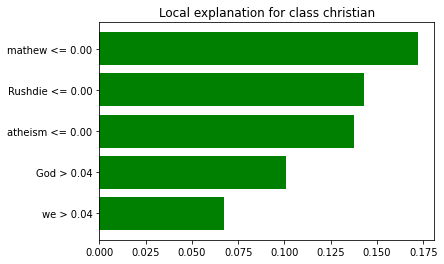

In [6]:
i = 3
print('Actual class: ', newsgroups_test.target[i])
print('Predit proba: ', sdg.predict_proba([test_vectors.toarray()[i]]))

# Get explanation FOR A SINGLE PERSON
exp = explainer.explain_instance(test_vectors.toarray()[i], sdg.predict_proba,
                                 num_features=5)

# Visualize the explanation 
%matplotlib inline
fig = exp.as_pyplot_figure()

In [5]:
# Trying TextExplainer (meant for text classifiers)
explainer_text = lime.lime_text.LimeTextExplainer(class_names=class_names)

In [6]:
# Using make_pipeline since LIME assumes raw text, & sklearn expects vectorized 
# inspired by LIME tutorials: https://github.com/marcotcr/lime

c = make_pipeline(vectorizer, sdg)

Actual class:  1
Predit proba:  [[0.01786429 0.98213571]]


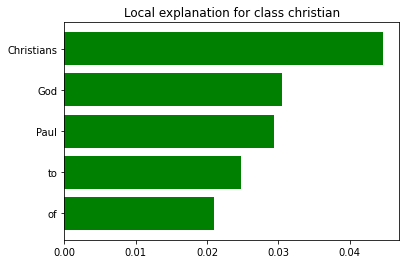

In [7]:
i = 3
print('Actual class: ', newsgroups_test.target[i])
print('Predit proba: ', c.predict_proba([newsgroups_test.data[i]]))
exp_text = explainer_text.explain_instance(newsgroups_test.data[i], c.predict_proba, num_features=5)

# Visualize the explanation 
fig = exp_text.as_pyplot_figure()

#### Doing this for 5 random samples (some correctly classified and some misclassified). Using TextExplainer because more suited to text classification and much faster.

In [8]:
nums = [random.randint(0,test_vectors.shape[0]-1) for i in range(5)]
print(nums)

[693, 44, 532, 123, 523]


Actual class:  0
Predit proba:  [[0.99781797 0.00218203]]


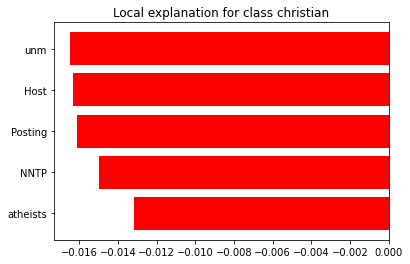

In [9]:
# Correct classification, atheist
i = nums[0]
print('Actual class: ', newsgroups_test.target[i])
print('Predit proba: ', c.predict_proba([newsgroups_test.data[i]]))
exp_text = explainer_text.explain_instance(newsgroups_test.data[i], c.predict_proba, num_features=5)
fig = exp_text.as_pyplot_figure()

Actual class:  1
Predit proba:  [[0.18927562 0.81072438]]


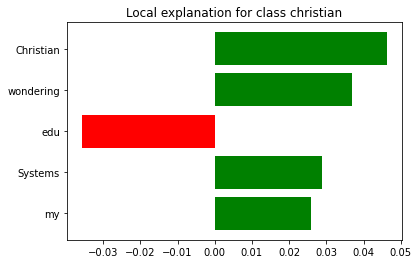

In [10]:
# Correct, christian
i = nums[1]
print('Actual class: ', newsgroups_test.target[i])
print('Predit proba: ', c.predict_proba([newsgroups_test.data[i]]))
exp_text = explainer_text.explain_instance(newsgroups_test.data[i], c.predict_proba, num_features=5)
fig = exp_text.as_pyplot_figure()

Actual class:  1
Predit proba:  [[0.02292418 0.97707582]]


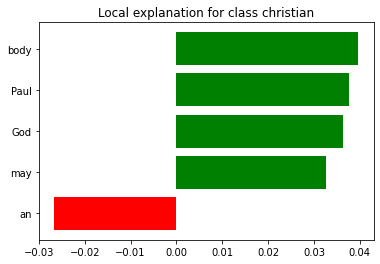

In [11]:
# Correct, christian
i = nums[2]
print('Actual class: ', newsgroups_test.target[i])
print('Predit proba: ', c.predict_proba([newsgroups_test.data[i]]))
exp_text = explainer_text.explain_instance(newsgroups_test.data[i], c.predict_proba, num_features=5)
fig = exp_text.as_pyplot_figure()

Actual class:  0
Predit proba:  [[0.21612009 0.78387991]]


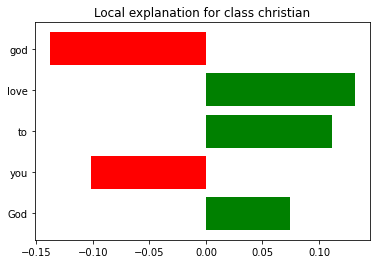

In [12]:
# Incorrect, actually atheist
i = nums[3]
print('Actual class: ', newsgroups_test.target[i])
print('Predit proba: ', c.predict_proba([newsgroups_test.data[i]]))
exp_text = explainer_text.explain_instance(newsgroups_test.data[i], c.predict_proba, num_features=5)
fig = exp_text.as_pyplot_figure()

Actual class:  1
Predit proba:  [[0.01170016 0.98829984]]


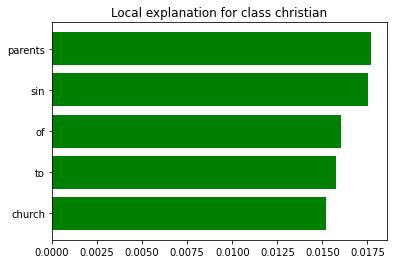

In [13]:
# Correct, christian
i = nums[4]
print('Actual class: ', newsgroups_test.target[i])
print('Predit proba: ', c.predict_proba([newsgroups_test.data[i]]))
exp_text = explainer_text.explain_instance(newsgroups_test.data[i], c.predict_proba, num_features=5)
fig = exp_text.as_pyplot_figure()

Actual class:  0
Predit proba:  [[0.19916822 0.80083178]]


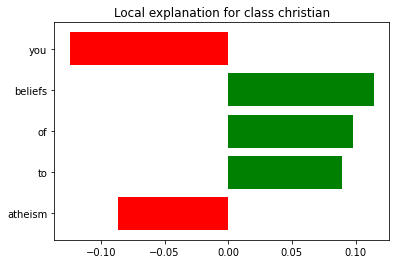

In [14]:
# Also incorrect, actually atheist
i = 469
print('Actual class: ', newsgroups_test.target[i])
print('Predit proba: ', c.predict_proba([newsgroups_test.data[i]]))
exp_text = explainer_text.explain_instance(newsgroups_test.data[i], c.predict_proba, num_features=5)
fig = exp_text.as_pyplot_figure()

#### Observations of explanataions above: 
Overall we see in a number of the explanations that positive explanations for Christianity include biblical and religious words such as ”Christian”, ”Paul”, ”God”, ”body”, ”sin”, whereas the features that explain atheism were often less meaningful (i.e. ”Host”, ”unm”, ”Jimmy”). One exception to this is the word ”edu” which explains the negative class, perhaps suggesting that the model has learned that scholarly emails ending in .edu are more likely to have the atheist class. Interestingly we see that (in line with religious treatments) ”God” contributes to the Christian class while ”god” explains the atheist class. In both classes we see that the model learned common words such as ”to”, ”of”, and ”an”, to explain both classes. Both cases of incorrect classifications had true labels of atheist and had negative and positive explanations for stop words like ”to” (positive), ”of” (positive), and ”you” (negative, but potentially indicating a more self-centric focus in line with atheism).

### Studying misclassified documents and the features (words) that contributed to their misclassification. 

In [15]:
def print_metrics(model, test_vectors):
    pred_test = model.predict(test_vectors)
    print("Test set f1 score: ", sklearn.metrics.f1_score(newsgroups_test.target, pred_test))
    print("Test set accuracy: ", sklearn.metrics.accuracy_score(newsgroups_test.target, pred_test))
    print("Test set number of misclassified documents: ", sklearn.metrics.zero_one_loss(newsgroups_test.target,
                                                                                        pred_test, normalize=False))

print_metrics(sdg, test_vectors)

Test set f1 score:  0.9505428226779252
Test set accuracy:  0.9428172942817294
Test set number of misclassified documents:  41


#### Looking at the difference between the probabilities of the two predicted classes (the magnitude of the error) for misclassified documents.

In [16]:
# Making predictions
pred_test = sdg.predict(test_vectors)

# Finding misclassified documents
misclassified = np.where(newsgroups_test.target != pred_test)[0]

In [17]:
# Getting difference in probabilities 
diffs = []
for i in misclassified:
    ath_prob = c.predict_proba([newsgroups_test.data[i]])[0][0]
    christ_prob = c.predict_proba([newsgroups_test.data[i]])[0][1]
    diff = np.abs(ath_prob - christ_prob)
    diffs.append(diff)

Text(0, 0.5, 'Number of documents')

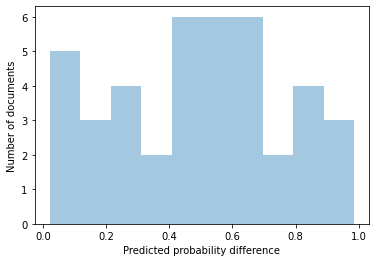

In [18]:
# Looking at distribution of probability difference 
sns.distplot(diffs, kde= False, bins=10)
plt.xlabel('Predicted probability difference')
plt.ylabel('Number of documents')

In [19]:
# What direction were most of the misclassifications in? Most are atheist miscalssified as Christian
misclassified_labels = []
for i in misclassified:
    actual = newsgroups_test.target[i]
    misclassified_labels.append(actual)

print('The number which were truly atheist but misclassified as Christian is:', misclassified_labels.count(0))
print('The number which were truly Christian but misclassified as atheist is:', misclassified_labels.count(1))

The number which were truly atheist but misclassified as Christian is: 37
The number which were truly Christian but misclassified as atheist is: 4


#### Identify words that contributed to the misclassification of some document.

In [20]:
# Finding all words that contributed to misclassification of any document (and weights)
wrong_vectors = []
for i in misclassified:
    # Make LIME explainer for each misclassified documents
    exp_text = explainer_text.explain_instance(newsgroups_test.data[i], c.predict_proba, num_features=10)
    actual = newsgroups_test.target[i]
    pred = c.predict([newsgroups_test.data[i]])[0]
    
    # Then adding features with weights opposite to the sign of the true class to a list
    if actual == 1: 
        incorrect = [i for i in exp_text.as_list() if i[1] <= 0]
        wrong_vectors.append(incorrect)
    elif actual == 0:
        incorrect = [i for i in exp_text.as_list() if i[1] >= 0]
        wrong_vectors.append(incorrect)  

In [21]:
# Make df of all words and weights across all documents
flat_list = [item for sublist in wrong_vectors for item in sublist]
vect_df = pd.DataFrame(flat_list, columns =['Word', 'Weight']) 
vect_df.head()

,Word,Weight
0,York,0.062619
1,to,0.058096
2,we,0.045962
3,Aaron,0.041035
4,temple,0.124943


Text(0, 0.5, 'Number of documents it helped misclassify')

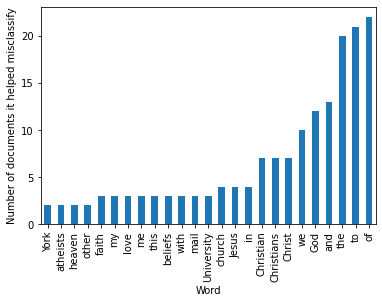

In [22]:
# Plot the number of documents each word helped misclassify- all that occured more than once

more_than_once = vect_df['Word'].value_counts()[vect_df['Word'].value_counts() > 1]
more_than_once.sort_values().plot(kind = 'bar')
plt.xlabel('Word')
plt.ylabel('Number of documents it helped misclassify')

Of the five words that helped to misclassify the most documents, four were common stop words (”of”, ”to”, ”the”, ”and”) and only one was related to religion (”God”). This suggests that the model learned stop words in one class direction but this failed to translate to the testing documents. There were five religious words in the top ten most misclassified words, ”God”, ”Christ”, ”Christian”, ”Christians”, ”church”, suggesting that these words are in fact used in both types of documents.

In [23]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (20, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

Text(0, 0.5, 'Number of documents it helped misclassify')

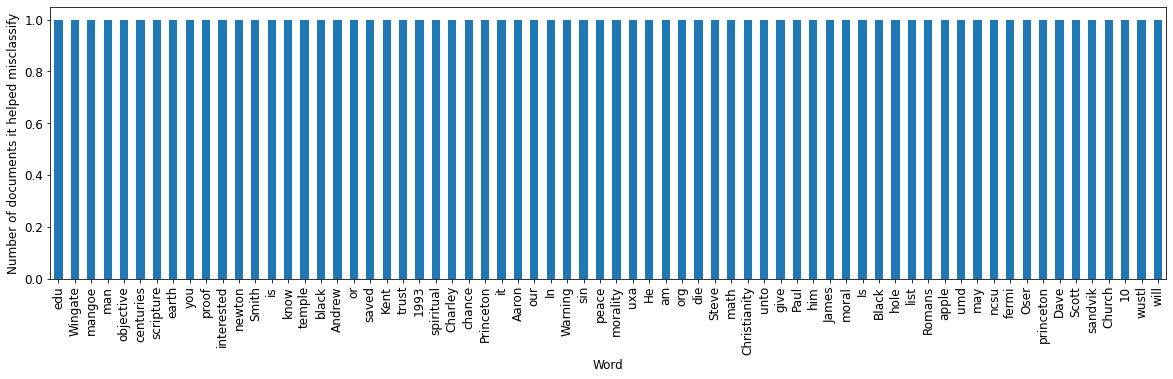

In [24]:
# Plot the number of documents each word helped misclassify- all that occured only once

occurs_once = vect_df['Word'].value_counts()[vect_df['Word'].value_counts() == 1]
occurs_once.sort_values().plot(kind = 'bar')
plt.xlabel('Word')
plt.ylabel('Number of documents it helped misclassify')

#### The total weight of each of these words was then calculated for all documents that it helped misclassify. This was done by summing the absolute values of the weight across all misclassified documents.

Text(0.5, 0, 'Word')

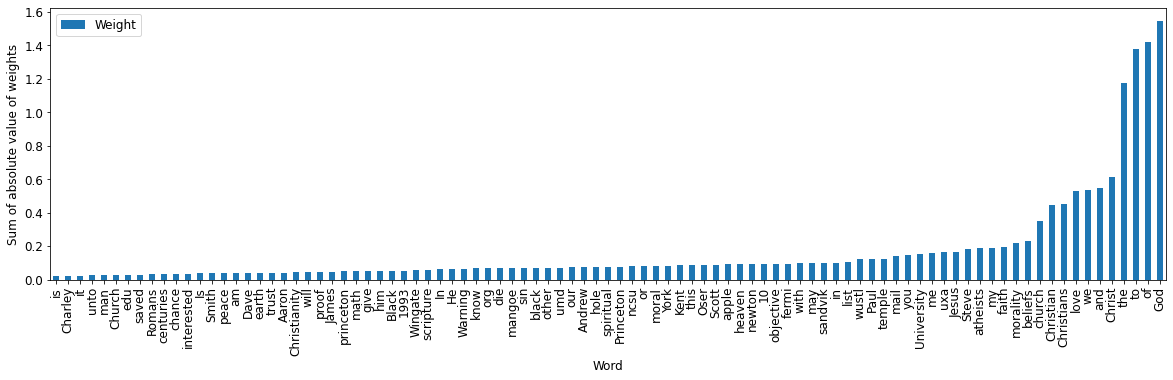

In [25]:
# Plot the total weight of that word in all documents it helped misclassify (sum of abs values of weights)
vect_df['Weight'] = vect_df['Weight'].abs()
sum_df = vect_df.groupby('Word').sum()

sum_df.sort_values('Weight').plot(kind = 'bar')
plt.ylabel('Sum of absolute value of weights')
plt.xlabel('Word')

We see a repeat of many of the words which commonly occurred in misclassified documents such as ”God”, ”of”, ”to”, and ”the”. Each of these words had a summed weight at least double of the next highest word (”Christ”), meaning that they often had large weights in the documents that they helped to misclassify.

### Investigate strategies for feature selection based on these explanations 

In [26]:
# Finding misclassified documents with predict_proba difference >= 0.1 (not close cases)
conf_docs = []
for i in misclassified:
    diff = np.abs(c.predict_proba([newsgroups_test.data[i]])[0][0] -
                      c.predict_proba([newsgroups_test.data[i]])[0][1])
    if diff >= 0.1:
        conf_docs.append(i)

# Get the wrong vectors from these documents
wrong_vectors = []
for i in conf_docs:
    exp_text = explainer_text.explain_instance(newsgroups_test.data[i], c.predict_proba, num_features=10)
    actual = newsgroups_test.target[i]    
    if actual == 1: 
        incorrect = [i for i in exp_text.as_list() if i[1] <= 0]
        wrong_vectors.append(incorrect)
    elif actual == 0:
        incorrect = [i for i in exp_text.as_list() if i[1] >= 0]
        wrong_vectors.append(incorrect) 
flat_list = [item for sublist in wrong_vectors for item in sublist]
vect_df = pd.DataFrame(flat_list, columns =['Word', 'Weight']) 

#### Strategy 1) Remove words/features that have a total weight > 0.5 and are misclassified more than 10 times

In [27]:
# Find words that have a total weight > 0.5 and are misclassified more than 10 times
words_to_remove = []
for word in set(vect_df['Word']):
    if len(vect_df[vect_df['Word'] == word]) > 10 and sum_df.loc[word]['Weight'] > 0.5:
        words_to_remove.append(word)
print(words_to_remove)

# Remove these words from training set 
X = train_vectors.toarray() # convert to dense
for word in words_to_remove:
    index = vectorizer.vocabulary_[word] 
    X[:, index] = 0 # remove from X
train_vectors_edited = sparse.csr_matrix(X) # convert back to sparse

# Retrain classifier
sdg_1 = SGDClassifier(loss='log',penalty= 'l2', max_iter= 50,
                                             alpha= 0.00001,fit_intercept= True, random_state=0)
sdg_1.fit(train_vectors_edited, newsgroups_train.target)

# Report new scores 
print_metrics(sdg_1, test_vectors)

['the', 'to', 'of', 'God', 'and']
Test set f1 score:  0.9516908212560387
Test set accuracy:  0.9442119944211994
Test set number of misclassified documents:  40


In [28]:
# Seeing which examples it fixed
misclassified_new = np.where(newsgroups_test.target != sdg_1.predict(test_vectors))[0]
diff_sets = list(set(misclassified_new).symmetric_difference(misclassified))
print('Difference of sets:', diff_sets)
print('Misclassified in new set, but not in old set:', np.setdiff1d(misclassified_new, misclassified))
print('Misclassified in old set, but not in new set:', np.setdiff1d(misclassified, misclassified_new))

Difference of sets: [148, 164, 80, 605, 366]
Misclassified in new set, but not in old set: [ 80 366]
Misclassified in old set, but not in new set: [148 164 605]


#### Strategy 2) Remove words/features that are misclassified more than once

In [29]:
# Removing words that are misclassified more than once - best performing experiment
words_to_remove = list(more_than_once.index)

# Remove these words from training set 
X = train_vectors.toarray() # convert to dense
for word in words_to_remove:
    index = vectorizer.vocabulary_[word] 
    X[:, index] = 0 # remove from X
train_vectors_edited = sparse.csr_matrix(X) # convert back to sparse

# Retrain classifier
sdg_new = SGDClassifier(loss='log',penalty= 'l2', max_iter= 50, alpha= 0.00001,fit_intercept= True, random_state=0)
sdg_new.fit(train_vectors_edited, newsgroups_train.target)

# Report new scores 
print_metrics(sdg_new, test_vectors)

Test set f1 score:  0.9564164648910412
Test set accuracy:  0.9497907949790795
Test set number of misclassified documents:  36


In [30]:
# Seeing which examples it fixed
misclassified_new = np.where(newsgroups_test.target != sdg_new.predict(test_vectors))[0]
diff_sets = list(set(misclassified_new).symmetric_difference(misclassified))
print('Difference of sets:', diff_sets)
print('Misclassified in new set, but not in old set:', np.setdiff1d(misclassified_new, misclassified))
print('Misclassified in old set, but not in new set:', np.setdiff1d(misclassified, misclassified_new))

Difference of sets: [641, 658, 280, 419, 164, 677, 62, 593, 605, 366, 377]
Misclassified in new set, but not in old set: [280 366 593]
Misclassified in old set, but not in new set: [ 62 164 377 419 605 641 658 677]


#### Strategy 3) Remove only stop words

In [31]:
# Removing just (English) stop words. Performance gets worse.

# Initialize tf-idf vectorizer
vectorizer_sw = sklearn.feature_extraction.text.TfidfVectorizer(stop_words= 'english', lowercase=False)

# Fit vectorizer on training data, then transform both the training and test data
train_vectors_nostop = vectorizer_sw.fit_transform(newsgroups_train.data)
test_vectors = vectorizer_sw.transform(newsgroups_test.data)

# Retrain classifier
sdg_stop = SGDClassifier(loss='log',penalty= 'l2', max_iter= 50, alpha= 0.00001,fit_intercept= True, random_state=0)
sdg_stop.fit(train_vectors_nostop, newsgroups_train.target)

# Report new scores 
print_metrics(sdg_stop, test_vectors)

Test set f1 score:  0.9492753623188406
Test set accuracy:  0.9414225941422594
Test set number of misclassified documents:  42


We see that strategy 2, removing words that are misclassified more than once results in the best improvement in accuracy, f-1 score, and reduces the number of misclassified documents the most.

#### Now looking at documents that were misclassified before feature selection, and that are classified correctly after feature selection.

Actual class:  1
Predit proba:  [[0.35635668 0.64364332]]


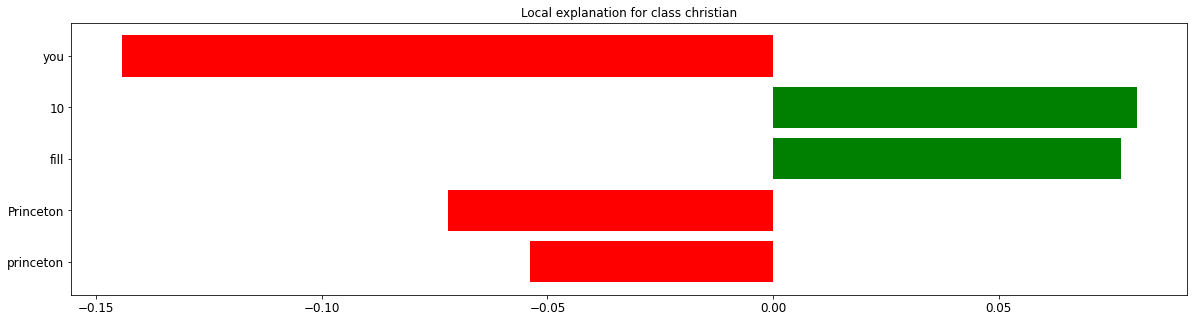

In [32]:
d = make_pipeline(vectorizer, sdg_new)

# New correctly classified version
i = 62
print('Actual class: ', newsgroups_test.target[i])
print('Predit proba: ', d.predict_proba([newsgroups_test.data[i]]))
exp_text = explainer_text.explain_instance(newsgroups_test.data[i], d.predict_proba, num_features=5)
fig = exp_text.as_pyplot_figure()

Actual class:  1
Predit proba:  [[0.51469448 0.48530552]]


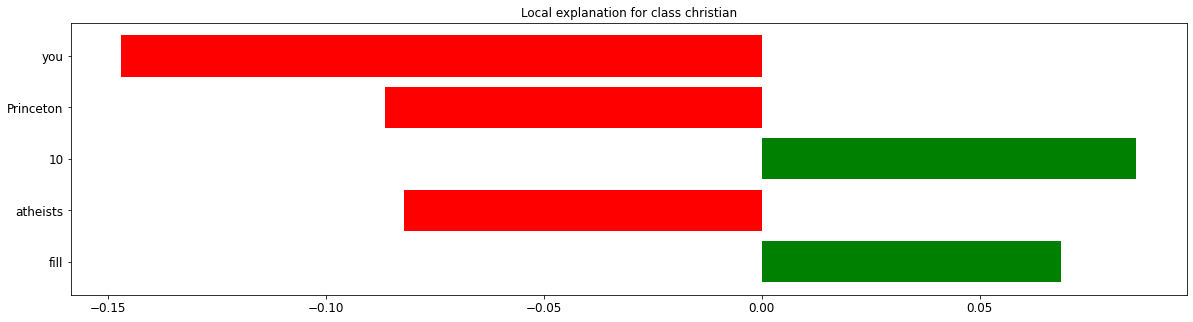

In [36]:
# Old version: incorrect
i = 62
print('Actual class: ', newsgroups_test.target[i])
print('Predit proba: ', c.predict_proba([newsgroups_test.data[i]]))
exp_text = explainer_text.explain_instance(newsgroups_test.data[i], c.predict_proba, num_features=5)
fig = exp_text.as_pyplot_figure()

Actual class:  0
Predit proba:  [[0.74233351 0.25766649]]


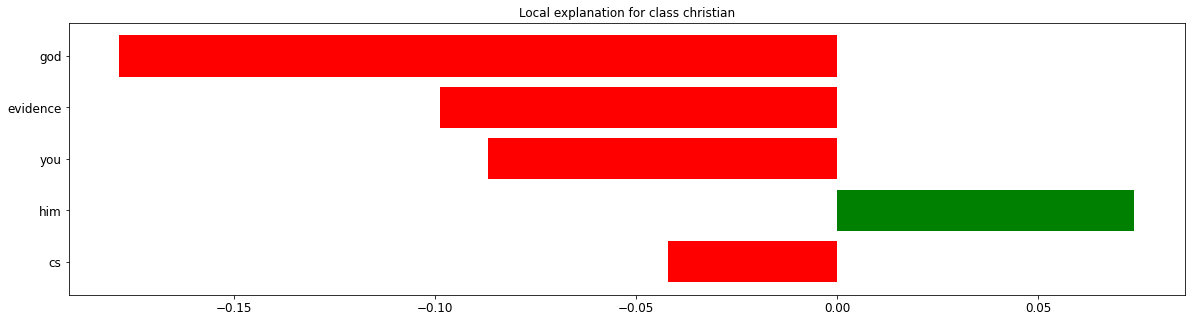

In [37]:
# New correctly classified version
i = 377
print('Actual class: ', newsgroups_test.target[i])
print('Predit proba: ', d.predict_proba([newsgroups_test.data[i]]))
exp_text = explainer_text.explain_instance(newsgroups_test.data[i], d.predict_proba, num_features=5)
fig = exp_text.as_pyplot_figure()

Actual class:  0
Predit proba:  [[0.3569371 0.6430629]]


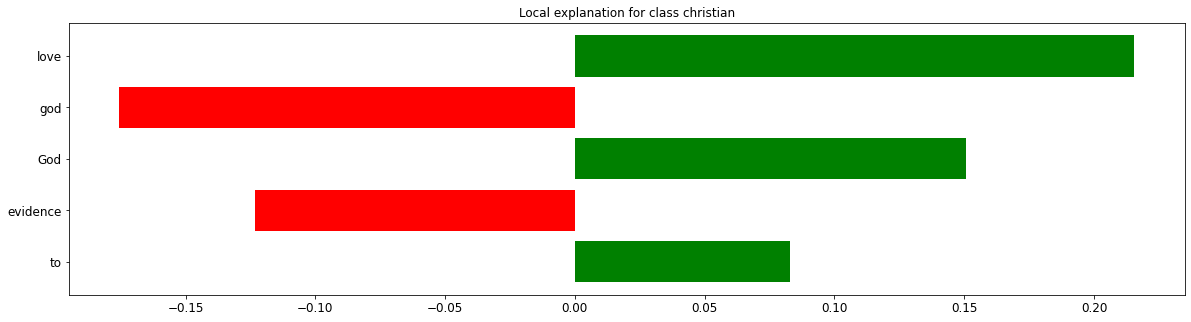

In [38]:
# Old version: incorrect
i = 377
print('Actual class: ', newsgroups_test.target[i])
print('Predit proba: ', c.predict_proba([newsgroups_test.data[i]]))
exp_text = explainer_text.explain_instance(newsgroups_test.data[i], c.predict_proba, num_features=5)
fig = exp_text.as_pyplot_figure()

Actual class:  0
Predit proba:  [[0.5762899 0.4237101]]


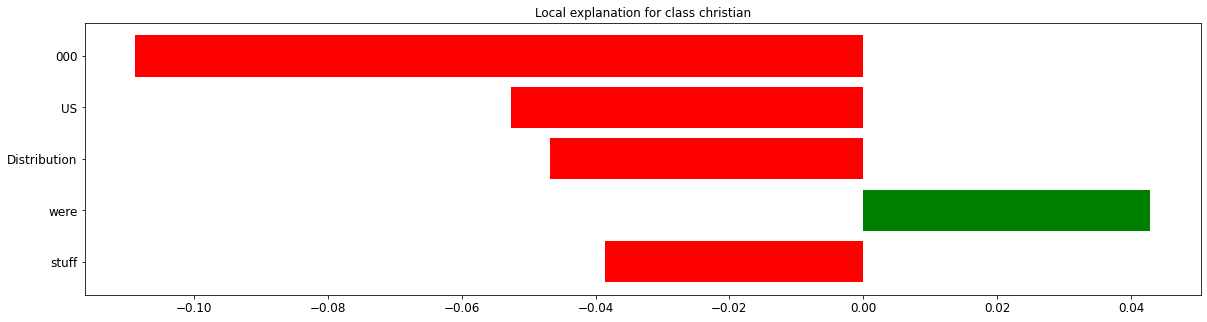

In [39]:
# New correctly classified version
i = 605
print('Actual class: ', newsgroups_test.target[i])
print('Predit proba: ', d.predict_proba([newsgroups_test.data[i]]))
exp_text = explainer_text.explain_instance(newsgroups_test.data[i], d.predict_proba, num_features=5)
fig = exp_text.as_pyplot_figure()

Actual class:  0
Predit proba:  [[0.48922469 0.51077531]]


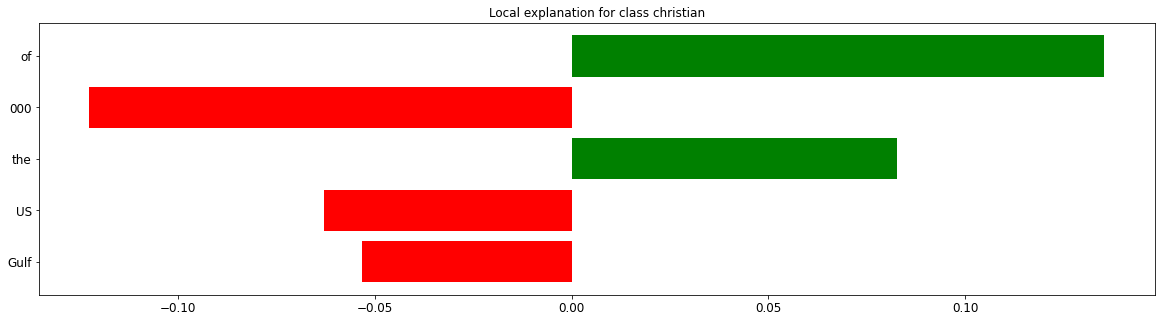

In [40]:
# Old version: incorrect
i = 605
print('Actual class: ', newsgroups_test.target[i])
print('Predit proba: ', c.predict_proba([newsgroups_test.data[i]]))
exp_text = explainer_text.explain_instance(newsgroups_test.data[i], c.predict_proba, num_features=5)
fig = exp_text.as_pyplot_figure()